# Аннотация

Данный проект выполнен **Бугаевым Егором Петровичем**, студентом группы БПМИИ 215 Факультета Компьютерных Наук НИУ ВШЭ в рамках курсовой работы на 2м курсе. 

Руководителем проекта выступил **Попов Виктор Юрьевич**: Доктор физико-математических наук, заведующий лабораторией моделирования и управления сложными системами факультета компьютерных наук НИУ ВШЭ

# Оглавление

>[Подготовка данных. Первые зарисовки.](#scrollTo=AXrp7gEbfi0X)

>[Часть 1. Кластеризация с помощью KMeans при количестве кластеров, подобранном вручную.](#scrollTo=FhjewrHDfp-K)

>[Часть 2. Кластеризация с помощью DBSCAN. Оценка качества кластеризации. Дополнительные тесты.](#scrollTo=TBh7LrkDfZzQ)



# Подготовка данных. Первые зарисовки.

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [21]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [11]:
data = pd.read_csv('gdrive/MyDrive/Colab Notebooks/AAA/earthquakes.csv')
plates = pd.read_csv('gdrive/MyDrive/Colab Notebooks/AAA/plates.csv')

Очистим данные, убрав все строки, где отсуствуют координаты (они нам совсем бесполезны, так как все рассуждениям основываются на локации).

In [22]:
data = data[data['Latitude'].notna()]
data = data[data['Longitude'].notna()]

In [23]:
plates = plates[plates['lat'].notna()]
plates = plates[plates['lon'].notna()]

In [5]:
data.head()
plates.head()

plate     lat      lon
0    am  30.754  132.824
1    am  30.970  132.965
2    am  31.216  133.197
3    am  31.515  133.500
4    am  31.882  134.042

In [141]:
fig = go.Figure(go.Scattermapbox(lat=data['Latitude'], \
                                 lon=data['Longitude'], \
                                 text=data['Location Name']))

map_center = go.layout.mapbox.Center()

fig.update_layout(mapbox_style="open-street-map", mapbox=dict(center=map_center, zoom=1), width=1280, height=720)
fig.show()

In [163]:
fig = go.Figure()

plate_names = list(plates["plate"].unique())
show_legend = True
for name in plate_names:
    this_plate = plates[plates["plate"] == name]
    ind_pairs = []
    start = 0
    for i in range(1, this_plate.shape[0]):
        if abs(this_plate.iloc[i]['lon'] - this_plate.iloc[i - 1]['lon']) > 250 \
            or abs(this_plate.iloc[i]['lat'] - this_plate.iloc[i - 1]['lat']) > 250:
          ind_pairs.append([start, i])
          start = i

    ind_pairs.append([start, this_plate.shape[0]])

    for p in ind_pairs:
      if p[1] - p[0] < 2:
          continue
    
      fig.add_trace(go.Scattermapbox(lat=this_plate.iloc[p[0]:p[1]]['lat'],
                                      showlegend=show_legend,
                                      lon=this_plate.iloc[p[0]:p[1]]['lon'], 
                                      text=this_plate.iloc[p[0]:p[1]]['plate'], 
                                      opacity=0.5,
                                      mode='lines',
                                      line=plotly.graph_objects.scattermapbox.Line(width=3),
                                      line_color='black',
                                      name="Tectonic plates boundaries"))
      show_legend = False

map_center = go.layout.mapbox.Center()
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.update_layout(mapbox_style="open-street-map", mapbox=dict(center=map_center), width=1280, height=720)
fig.show()

Наложим графики один на другой:

In [162]:
fig = go.Figure()

fig.add_trace(go.Scattermapbox(lat=data['Latitude'], 
                               lon=data['Longitude'], 
                               text=data['Location Name'], 
                               fillcolor='Blue', 
                               name="Earthquakes locations"))

plate_names = list(plates["plate"].unique())
show_legend = True
for name in plate_names:
    this_plate = plates[plates["plate"] == name]
    ind_pairs = []
    start = 0
    for i in range(1, this_plate.shape[0]):
        if abs(this_plate.iloc[i]['lon'] - this_plate.iloc[i - 1]['lon']) > 250 \
            or abs(this_plate.iloc[i]['lat'] - this_plate.iloc[i - 1]['lat']) > 250:
          ind_pairs.append([start, i])
          start = i

    ind_pairs.append([start, this_plate.shape[0]])

    for p in ind_pairs:
      if p[1] - p[0] < 2:
          continue
    
      fig.add_trace(go.Scattermapbox(lat=this_plate.iloc[p[0]:p[1]]['lat'],
                                      showlegend=show_legend,
                                      lon=this_plate.iloc[p[0]:p[1]]['lon'], 
                                      text=this_plate.iloc[p[0]:p[1]]['plate'], 
                                      opacity=0.5,
                                      mode='lines',
                                      line=plotly.graph_objects.scattermapbox.Line(width=3),
                                      line_color='black',
                                      name="Tectonic plates boundaries"))
      show_legend = False

map_center = go.layout.mapbox.Center()
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.update_layout(mapbox_style="open-street-map", mapbox=dict(center=map_center, zoom=1), width=1280, height=720)
fig.show()

In [184]:
fig = go.Figure()

data_mag = data[data['Mag'].notna()]
fig.add_trace(go.Scattermapbox(lat=data_mag['Latitude'], 
                               lon=data_mag['Longitude'], 
                               text=data_mag['Location Name'], 
                               marker=dict(colorbar=dict(title="Magnitude"),
                                             color=data_mag['Mag']), 
                               name="Magnitude"))

plate_names = list(plates["plate"].unique())
show_legend = True
for name in plate_names:
    this_plate = plates[plates["plate"] == name]
    ind_pairs = []
    start = 0
    for i in range(1, this_plate.shape[0]):
        if abs(this_plate.iloc[i]['lon'] - this_plate.iloc[i - 1]['lon']) > 250 \
            or abs(this_plate.iloc[i]['lat'] - this_plate.iloc[i - 1]['lat']) > 250:
          ind_pairs.append([start, i])
          start = i

    ind_pairs.append([start, this_plate.shape[0]])

    for p in ind_pairs:
      if p[1] - p[0] < 2:
          continue
    
      fig.add_trace(go.Scattermapbox(lat=this_plate.iloc[p[0]:p[1]]['lat'],
                                      showlegend=show_legend,
                                      lon=this_plate.iloc[p[0]:p[1]]['lon'], 
                                      text=this_plate.iloc[p[0]:p[1]]['plate'], 
                                      opacity=0.5,
                                      mode='lines',
                                      line=plotly.graph_objects.scattermapbox.Line(width=3),
                                      line_color='black',
                                      name="Tectonic plates boundaries"))
      show_legend = False

map_center = go.layout.mapbox.Center()

fig.update_layout(mapbox_style="open-street-map", mapbox=dict(center=map_center, zoom=1), width=1280, height=720)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.show()

По этой карте уже видно, что значительная часть сильных землятресений проходит на стыке восточной границе Евразийской плиты, Тихоокеанской плиты и Северо-американской, а так же в расположенном рядом районе Филлипинской плиты. На южной границе Евразийской плиты земелетрясения тоже частое явление, однако, как можно заметить по графику, их средняя магнитуда значительно меньше. Дальше попробуем кластеризовать наши землетрясения и подтвердить это заключение математической статистикой.

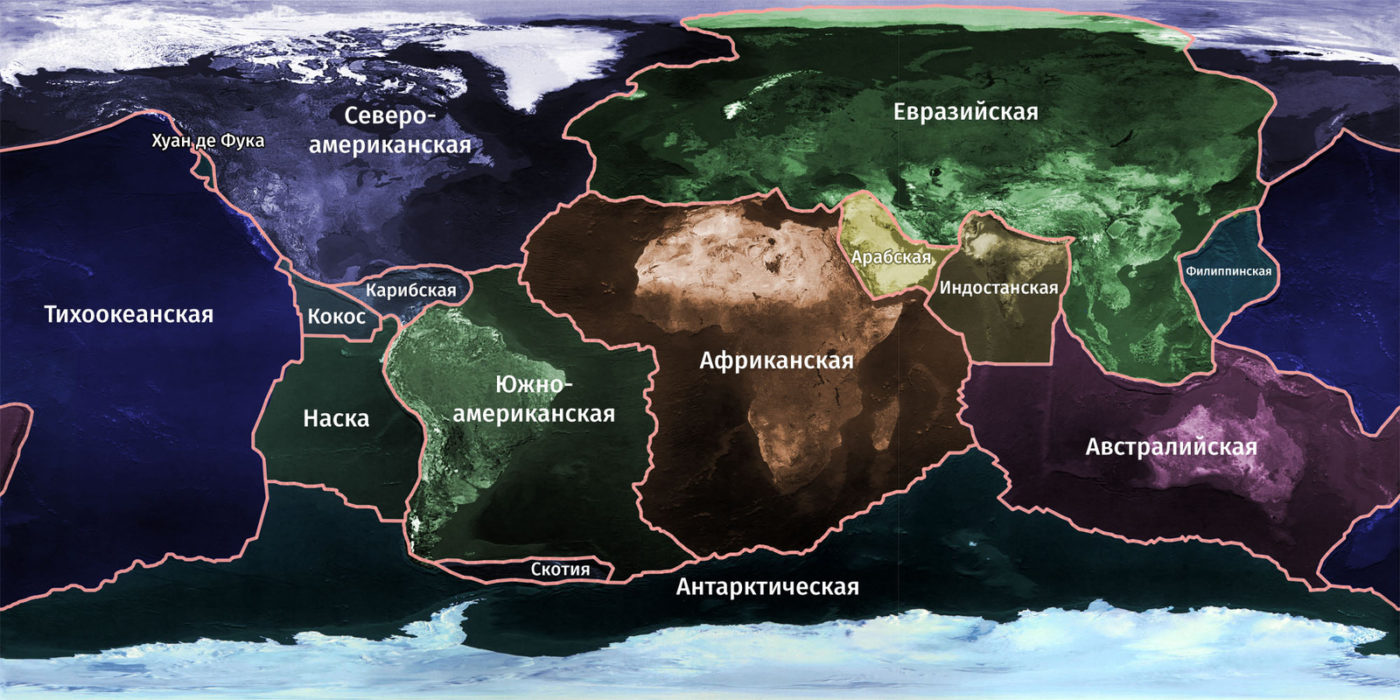

Заметим, что мы все еще учитываем значительное количество землетрясений, которые произошли вдали от тектонических плит. Давайти избавимся от них, применив алгоритм DBSCAN (подробнее про него будет ниже в Части 2). 

Этот алгоритм хорошо выделяет длинные скучкованные кластера. Для того, чтобы оставить только точки вдоль линий тектонических разломов, очистим данные следующим образом. 

Добавим точки вдоль линий разломов (датасет plates) в наш датасет data. Затем проведем кластеризацию с помощью метода DBSCAN, при этом точки вдоль тектонических плит выступают в роли связующих элементов для кластеров вдоль тектонических плит. Это позволит нам выделить один кластер землятресений вдоль разломов. Все не попавшие в него землетрясения откинем (они удаленны от границ плит и нас не интересуют).

DBNOSCAN концентрирует кластера вокруг скоплений точек вблизи друг друга. Добавим границы тектонических плит в датасет несколько раз, тем самым они будут более явными ориентирами для алгоритма и позволят лучше сконцентрировать землятресения вокруг них.

Параметры для запуска DBSCAN подбираем вручную. Параметр min_samples отвечает за минимальное количество точек, которые должны находиться близко друг к другу, чтобы образовать отдельный кластер (близость определяется параметром eps). 

Выставляем параметр 15 для минимального количества точек, необходимых для образования кластера. При этом точки на границах добавляем чуть меньше раз, тем самым это почти достаточно для формирования кластера, но не совсем - все еще нужны землятресения рядом.

In [24]:
from sklearn.cluster import DBSCAN

In [25]:
data_for_clusters = data[['Latitude', 'Longitude']]
plates_for_clusters = plates.drop('plate', axis=1)
for i in range(5):
    total_clusters = pd.concat([data_for_clusters, plates_for_clusters.rename(columns={'lat':'Latitude', 'lon': 'Longitude'})])

kmeans = DBSCAN(eps=2, min_samples=15).fit(total_clusters) 
data['db_clear_label'] = kmeans.labels_[:data_for_clusters.shape[0]]

In [8]:
fig = go.Figure()
clusters = list(data['db_clear_label'].unique())
for cluster in clusters:
  data_cluster = data[data['db_clear_label'] == cluster]
  

  fig.add_trace(go.Scattermapbox(lat=data_cluster['Latitude'], 
                                lon=data_cluster['Longitude'], 
                                text=data_cluster['Location Name'], 
                                marker=dict(color=cluster), 
                                name="Cluster " + str(cluster)))

plate_names = list(plates["plate"].unique())
show_legend = True
for name in plate_names:
    this_plate = plates[plates["plate"] == name]
    ind_pairs = []
    start = 0
    for i in range(1, this_plate.shape[0]):
        if abs(this_plate.iloc[i]['lon'] - this_plate.iloc[i - 1]['lon']) > 250 \
            or abs(this_plate.iloc[i]['lat'] - this_plate.iloc[i - 1]['lat']) > 250:
          ind_pairs.append([start, i])
          start = i

    ind_pairs.append([start, this_plate.shape[0]])

    for p in ind_pairs:
      if p[1] - p[0] < 2:
          continue
    
      fig.add_trace(go.Scattermapbox(lat=this_plate.iloc[p[0]:p[1]]['lat'],
                                      showlegend=show_legend,
                                      lon=this_plate.iloc[p[0]:p[1]]['lon'], 
                                      text=this_plate.iloc[p[0]:p[1]]['plate'], 
                                      opacity=0.5,
                                      mode='lines',
                                      line=plotly.graph_objects.scattermapbox.Line(width=3),
                                      line_color='black',
                                      name="Tectonic plates boundaries"))
      show_legend = False

map_center = go.layout.mapbox.Center()

fig.update_layout(mapbox_style="open-street-map", mapbox=dict(center=map_center, zoom=1), width=1280, height=720)
fig.show()

Действительно, замечаем, что большая часть точек на сильном удалении от границ попала в кластер -1 (то есть ни в какой кластер). Удалим эти точки из набора данных.

In [26]:
data = data[data['db_clear_label'] != -1]
data = data.drop('db_clear_label', axis=1)

In [17]:
fig = go.Figure()

fig.add_trace(go.Scattermapbox(lat=data['Latitude'], 
                               lon=data['Longitude'], 
                               text=data['Location Name'], 
                               fillcolor='Blue', 
                               name="Earthquakes locations"))

plate_names = list(plates["plate"].unique())
show_legend = True
for name in plate_names:
    this_plate = plates[plates["plate"] == name]
    ind_pairs = []
    start = 0
    for i in range(1, this_plate.shape[0]):
        if abs(this_plate.iloc[i]['lon'] - this_plate.iloc[i - 1]['lon']) > 250 \
            or abs(this_plate.iloc[i]['lat'] - this_plate.iloc[i - 1]['lat']) > 250:
          ind_pairs.append([start, i])
          start = i

    ind_pairs.append([start, this_plate.shape[0]])

    for p in ind_pairs:
      if p[1] - p[0] < 2:
          continue
    
      fig.add_trace(go.Scattermapbox(lat=this_plate.iloc[p[0]:p[1]]['lat'],
                                      showlegend=show_legend,
                                      lon=this_plate.iloc[p[0]:p[1]]['lon'], 
                                      text=this_plate.iloc[p[0]:p[1]]['plate'], 
                                      opacity=0.5,
                                      mode='lines',
                                      line=plotly.graph_objects.scattermapbox.Line(width=3),
                                      line_color='black',
                                      name="Tectonic plates boundaries"))
      show_legend = False

map_center = go.layout.mapbox.Center()
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.update_layout(mapbox_style="open-street-map", mapbox=dict(center=map_center, zoom=1), width=1280, height=720)
fig.show()

# Часть 1. Кластеризация с помощью KMeans при количестве кластеров, подобранном вручную.

In [18]:
from sklearn.cluster import KMeans

In [19]:
data_for_clusters = data[['Latitude', 'Longitude']]
kmeans = KMeans(n_clusters=15, init='random', n_init=20, random_state=42).fit(data_for_clusters) # 15 as number of tectonic plates
data['k_label'] = kmeans.labels_

In [66]:
fig = go.Figure()
clusters = list(data['k_label'].unique())
for cluster in clusters:
  data_cluster = data[data['k_label'] == cluster]

  fig.add_trace(go.Scattermapbox(lat=data_cluster['Latitude'], 
                                lon=data_cluster['Longitude'], 
                                text=data_cluster['Location Name'], 
                                marker=dict(color=cluster), 
                                name="Cluster " + str(cluster)))

map_center = go.layout.mapbox.Center()
fig.update_layout(mapbox_style="open-street-map", mapbox=dict(center=map_center, zoom=1), width=1280, height=720)
fig.show()

Кластеризуем методом KMeans (алгоритм Ллойда), разбиваем на 15 кластеров. 15 здесь выбрано как количество тектонических плит (хотим определить каждое землетрясение к сдвигу той или иной плиты или границе двух плит).

Стартовые центры кластеров перед применением метода выбираются случайно.

Алгоритм был запущен с различными random_state (например, 22, 33, 44), что позволяет говорит о стабильности работы. Параметры - 20 итераций.

Сразу можем сделать набор интересных наблюдений: на стыке Южно-Американской плиты с ее западными соседями: плитой Наска и Карибской плитой алгоритм правильно выделил границы землятресений.

In [61]:
fig = go.Figure()
clusters = list(data['k_label'].unique())
for cluster in clusters:
  data_cluster = data[data['k_label'] == cluster]

  fig.add_trace(go.Scattermapbox(lat=data_cluster['Latitude'], 
                                lon=data_cluster['Longitude'], 
                                text=data_cluster['Location Name'], 
                                marker=dict(color=cluster), 
                                name="Cluster " + str(cluster)))

plate_names = list(plates["plate"].unique())
show_legend = True
for name in plate_names:
    this_plate = plates[plates["plate"] == name]
    ind_pairs = []
    start = 0
    for i in range(1, this_plate.shape[0]):
        if abs(this_plate.iloc[i]['lon'] - this_plate.iloc[i - 1]['lon']) > 250 \
            or abs(this_plate.iloc[i]['lat'] - this_plate.iloc[i - 1]['lat']) > 250:
          ind_pairs.append([start, i])
          start = i

    ind_pairs.append([start, this_plate.shape[0]])

    for p in ind_pairs:
      if p[1] - p[0] < 2:
          continue
    
      fig.add_trace(go.Scattermapbox(lat=this_plate.iloc[p[0]:p[1]]['lat'],
                                      showlegend=show_legend,
                                      lon=this_plate.iloc[p[0]:p[1]]['lon'], 
                                      text=this_plate.iloc[p[0]:p[1]]['plate'], 
                                      opacity=0.5,
                                      mode='lines',
                                      line=plotly.graph_objects.scattermapbox.Line(width=3),
                                      line_color='black',
                                      name="Tectonic plates boundaries"))
      show_legend = False

map_center = go.layout.mapbox.Center()

fig.update_layout(mapbox_style="open-street-map", mapbox=dict(center=map_center, zoom=1), width=1280, height=720)
fig.show()



Посчитаем средние значения в каждом кластере, попробуем проверить идею, что на востоке Евразийской плиты средняя магнитуда выще, чем в остальных местах. Для проверки существенности различия воспользуемся двухвыборочным t-критерием для независимых выборок.

Проверим наше изначальное предположение: на стыке Евразийской плиты, Тихоокеанской плиты и Северо-американской, а так же в расположенном рядом районе Филлипинской плиты средняя магнитуда землятресений выше, чем средняя магнитуда на южной границе Евразийской плиты (с Африканской, Арабской и Индостанской соответственно).

Тогда получаем:

- **Кластер 0**: Стык Евразийской, Тихоокеанской, Североамериканской и Филлипинской плиты.
- **Кластеры 10, 11, 13**: Стык Евразийской и Африканской плиты.
- **Кластер 6**: Стык Евразийской и Арабаской (Аравийской) плиты.
- **Кластер 12**: Стык Евразийской и Индостанской плиты.

Проведем t-test, сравнив среднюю магнитуду попарно для каждого из 4 наборов кластеров выше. Сначала посчитаем дисперсию магнитуды в каждом из кластеров, чтобы узнать, какой из вариантов t-test'а нам подходит.

In [67]:
def get_std_for_clusters(clusters): 
    data_cluster = data.loc[data['k_label'].isin(clusters)]
    data_cluster = data_cluster[data_cluster['Mag'].notna()]
    return np.std(data_cluster['Mag'])

print('Cluster 0 std magnitude:', get_std_for_clusters([0]))
print('Cluster 10, 11, 13 std magnitude:', get_std_for_clusters([10, 11, 13]))
print('Cluster 6 std magnitude:', get_std_for_clusters([6]))
print('Cluster 12 std magnitude:', get_std_for_clusters([12]))

Cluster 0 std magnitude: 0.7942879484986037
Cluster 10, 11, 13 std magnitude: 0.9056328870539904
Cluster 6 std magnitude: 0.8413389989542351
Cluster 12 std magnitude: 0.9064956648353634


Будем использовать тест, подразумевающий одинаковую дисперсию, для сравнения наборов, у которых дисперсия отличается меньше, чем на 0.02

In [69]:
def get_mean_for_clusters(clusters): 
    data_cluster = data.loc[data['k_label'].isin(clusters)]
    data_cluster = data_cluster[data_cluster['Mag'].notna()]
    return np.mean(data_cluster['Mag'])


print('Cluster 0 mean magnitude:', get_mean_for_clusters([0]))
print('Cluster 10, 11, 13 mean magnitude:', get_mean_for_clusters([10, 11, 13]))
print('Cluster 6 mean magnitude:', get_mean_for_clusters([6]))
print('Cluster 12 mean magnitude:', get_mean_for_clusters([12]))

Cluster 0 mean magnitude: 7.002087682672234
Cluster 10, 11, 13 mean magnitude: 6.024432809773124
Cluster 6 mean magnitude: 5.830748663101604
Cluster 12 mean magnitude: 6.097212543554007


Запускаем попарный t_test:

In [70]:
import scipy.stats

In [74]:
def run_t_test(clusters_a, clusters_b): 
    data_cluster_a = data.loc[data['k_label'].isin(clusters_a)]
    data_cluster_a = data_cluster_a[data_cluster_a['Mag'].notna()]
    data_cluster_b = data.loc[data['k_label'].isin(clusters_b)]
    data_cluster_b = data_cluster_b[data_cluster_b['Mag'].notna()]

    std_diff = abs(get_std_for_clusters(clusters_a) - get_std_for_clusters(clusters_b))
    return scipy.stats.ttest_ind(data_cluster_a['Mag'], data_cluster_b['Mag'], equal_var=(std_diff<0.02), random_state=42)

cluster_options = [[0], [10, 11, 13], [6], [12]]

for i in range(len(cluster_options)):
    for j in range(i + 1, len(cluster_options)):
        print("t_test for clusters ", cluster_options[i], " and ", cluster_options[j], ": ", run_t_test(cluster_options[i], cluster_options[j]))

t_test for clusters  [0]  and  [10, 11, 13] :  Ttest_indResult(statistic=18.63053050757514, pvalue=3.915460808955481e-67)
t_test for clusters  [0]  and  [6] :  Ttest_indResult(statistic=20.649882250310057, pvalue=6.944185117498609e-76)
t_test for clusters  [0]  and  [12] :  Ttest_indResult(statistic=13.974080341477942, pvalue=4.1525875505034873e-38)
t_test for clusters  [10, 11, 13]  and  [6] :  Ttest_indResult(statistic=3.3555854519634902, pvalue=0.00082760185265858)
t_test for clusters  [10, 11, 13]  and  [12] :  Ttest_indResult(statistic=-1.10897020889167, pvalue=0.26790946586515857)
t_test for clusters  [6]  and  [12] :  Ttest_indResult(statistic=-3.8577776809894178, pvalue=0.00012700493445206838)


Возьмем уровень доверия в 0.01.

Так как наша нулевая гипотеза в данном случае была о равенстве средних магниту в данных областях, во всех случаях, кроме [10, 11, 13] и [12] (стык Евразийской и Африканской и стык Евразийской и Индостанской плиты) мы можем говорить о значимой разности в средней магнитуде землятресений.

При этом наша изначальная гипотеза, что на стыке 4 тектнонических плит наиболее сильные землятресения из всех участков, совпдающих с Евразийской тектонической плитой, данными наблюдениями подтверждаются - там действительно наиболее сильная средняя магнитуда и отличия значимые, что подтверждает t-test.

# Часть 2. Кластеризация с помощью DBSCAN. Проверка еще одной гипотезы.

Попробуем приминить другой алгоритм кластеризации, который часто применяют для кластеризации геоданных (кластера в них часто имеют необычную форму): DBSCAN. 

Значения подобраны вручную путем многократного запуска, но попробуем дальше оптимизировать их в оценке кластеризации.

In [4]:
from sklearn.cluster import DBSCAN

In [106]:
data_for_clusters = data[['Latitude', 'Longitude']]

kmeans = DBSCAN(eps=2, min_samples=8).fit(data_for_clusters) 
data['db_label'] = kmeans.labels_[:data_for_clusters.shape[0]]

In [107]:
fig = go.Figure()
clusters = list(data['db_label'].unique())
for cluster in clusters:
  data_cluster = data[data['db_label'] == cluster]
  

  fig.add_trace(go.Scattermapbox(lat=data_cluster['Latitude'], 
                                lon=data_cluster['Longitude'], 
                                text=data_cluster['Location Name'], 
                                marker=dict(color=cluster), 
                                name="Cluster " + str(cluster)))

plate_names = list(plates["plate"].unique())
show_legend = True
for name in plate_names:
    this_plate = plates[plates["plate"] == name]
    ind_pairs = []
    start = 0
    for i in range(1, this_plate.shape[0]):
        if abs(this_plate.iloc[i]['lon'] - this_plate.iloc[i - 1]['lon']) > 250 \
            or abs(this_plate.iloc[i]['lat'] - this_plate.iloc[i - 1]['lat']) > 250:
          ind_pairs.append([start, i])
          start = i

    ind_pairs.append([start, this_plate.shape[0]])

    for p in ind_pairs:
      if p[1] - p[0] < 2:
          continue
    
      fig.add_trace(go.Scattermapbox(lat=this_plate.iloc[p[0]:p[1]]['lat'],
                                      showlegend=show_legend,
                                      lon=this_plate.iloc[p[0]:p[1]]['lon'], 
                                      text=this_plate.iloc[p[0]:p[1]]['plate'], 
                                      opacity=0.5,
                                      mode='lines',
                                      line=plotly.graph_objects.scattermapbox.Line(width=3),
                                      line_color='black',
                                      name="Tectonic plates boundaries"))
      show_legend = False

map_center = go.layout.mapbox.Center()

fig.update_layout(mapbox_style="open-street-map", mapbox=dict(center=map_center, zoom=1), width=1280, height=720)
fig.show()



Заметим, что DBSCAN опредилил мало точек вне кластеров, что говорит о малом количестве выбросов (если алгоритм обнаруживает точку с малым количеством соседей на расстоянии меньше eps, он определяет ее в кластер -1).

Снова сравним концентрацию землятресений на пересечении 4 плит и южную границу Евразийской плиты на значимые отличия в среденей силе землятресений.

Здесь имеем:
- **Кластер 4**: стык 4 тектонических плит (включая восток Евразийской).
- **Кластер 1 и 0**: стыки на южной границе Евразийской плиты с Африканской и Аравийской. 
- **Кластер 3**: стык Евразийской и Индостанской плиты


In [114]:
def get_std_for_clusters_db(clusters): 
    data_cluster = data.loc[data['db_label'].isin(clusters)]
    data_cluster = data_cluster[data_cluster['Mag'].notna()]
    return np.std(data_cluster['Mag'])

def get_mean_for_clusters_db(clusters): 
    data_cluster = data.loc[data['db_label'].isin(clusters)]
    data_cluster = data_cluster[data_cluster['Mag'].notna()]
    return np.mean(data_cluster['Mag'])

print('Cluster 4 std magnitude:', get_std_for_clusters_db([4]))
print('Cluster [1, 0] std magnitude:', get_std_for_clusters_db([1, 0]))
print('Cluster 3 std magnitude:', get_std_for_clusters_db([3]))

print('-' * 50)

print('Cluster 4 mean magnitude:', get_mean_for_clusters_db([4]))
print('Cluster [1, 0] mean magnitude:', get_mean_for_clusters_db([1, 0]))
print('Cluster 3 mean magnitude:', get_mean_for_clusters_db([3]))

Cluster 4 std magnitude: 0.7786952311037914
Cluster [1, 0] std magnitude: 0.8779306048375858
Cluster 3 std magnitude: 0.8098957066866382
--------------------------------------------------
Cluster 4 mean magnitude: 6.944711538461538
Cluster [1, 0] mean magnitude: 5.955701311806257
Cluster 3 mean magnitude: 6.078947368421052


Снова запускаем t-test: 

In [117]:
def run_t_test(clusters_a, clusters_b): 
    data_cluster_a = data.loc[data['db_label'].isin(clusters_a)]
    data_cluster_a = data_cluster_a[data_cluster_a['Mag'].notna()]
    data_cluster_b = data.loc[data['db_label'].isin(clusters_b)]
    data_cluster_b = data_cluster_b[data_cluster_b['Mag'].notna()]

    std_diff = abs(get_std_for_clusters_db(clusters_a) - get_std_for_clusters_db(clusters_b))
    return scipy.stats.ttest_ind(data_cluster_a['Mag'], data_cluster_b['Mag'], equal_var=(std_diff<0.02), random_state=42)

cluster_options = [[4], [1, 0], [3]]

for i in range(len(cluster_options)):
    for j in range(i + 1, len(cluster_options)):
        print("t_test for clusters ", cluster_options[i], " and ", cluster_options[j], ": ", run_t_test(cluster_options[i], cluster_options[j]))

t_test for clusters  [4]  and  [1, 0] :  Ttest_indResult(statistic=20.898189100939476, pvalue=6.261377712695511e-79)
t_test for clusters  [4]  and  [3] :  Ttest_indResult(statistic=11.870322211803687, pvalue=5.6242815467274475e-27)
t_test for clusters  [1, 0]  and  [3] :  Ttest_indResult(statistic=-1.8099063158477733, pvalue=0.07154154504346019)


При интервале доверия в 0.01 получаем, что можем отвергнуть нулевую гипотезу о равенстве средней магнитуды в кластере [4] и остальных, а значит снова подтверждаем наше утверждение - землятресения в той области активнее. 

# Часть 3. Оценка качества кластеризации. Метрики качества.

Попробуем оценить качество разбиения на кластеры с помощью DBSCAN и KMeans. 

Для оценивания качества кластеризации выберем следующие метрики. Заметим сразу, что здесь показатели метрик не будут являться однозначным указателем на оптимальность того или другого разбиения на кластеры, так как мы хотим разбить на кластеры нестанадртных размеров, но все еще интересны для изучения: 

- Average silhouette score: метрика схожести объектов внутри одного кластера в сравнении с объектами из других кластеров - для каждой точки метрика подсчитывается используя среднее расстояние между точками в ее кластере и расстоянием от нее до ближайшего кластера.

- Adjusted Rand Index: эта метрика кластеризации требует знания заранее известных эталонных кластеров для части данных (для нас это границы тектонических плит). Она оценивает количество пар из одного эталонного кластера.

Специально не берем метрики, основанные на дисперсии внутри кластера, так как наши кластера здесь часто имеют вытянутую форму (а значит большую дисперсию по одному из измерений), что нивелирует смысл этих тестов. Примером метрики из такого класса будет ..., про которую можно прочитать в статье ее автора \cite{}.

Для того, чтобы лучше понять, какой алгоритм выигрывает в метриках, попробуем запустить наши алгоритмы с разными параметрами (включая использованные выше для кластеризации) и посмотреть, при каких параметрах метрики будут лучше, и правда ли, что эти параметры выделяют нам оптимальные зоны для нашей задачи.

In [34]:
from sklearn.metrics import silhouette_score
import plotly.express as px

In [33]:
x_values = list(range(3, 20, 2))
y_values = []
for i in x_values:
  data_for_clusters = data[['Latitude', 'Longitude']]
  kmeans = KMeans(n_clusters=i, init='random', n_init=20, random_state=42).fit(data_for_clusters) # 15 as number of tectonic plates
  data['k_label'] = kmeans.labels_
  y_values.append(silhouette_score(data_for_clusters, kmeans.labels_))

In [70]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=[15, 15], y=[min(y_values)-0.01, max(y_values)+0.01],
                    line = dict(color=px.colors.qualitative.Plotly[1], width=2, dash='dash'),
                    name='Использованное значение'))
fig.add_trace(go.Scatter(x=x_values, y=y_values,
                    mode='lines+markers',
                    marker = dict(size=10, color=px.colors.qualitative.Plotly[0]),
                    line = dict(color=px.colors.qualitative.Plotly[0]),
                    name='Silhoette score для KMeans'))

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99, 
    font_size=16
))

fig.update_layout(title='Silhouette score для алгоритма KMeans',
                   xaxis_title='Количество кластеров',
                   yaxis_title='Silhouette score')
fig.update_layout(width=1280, height=720)
fig.show()

In [83]:
data_for_clusters = data[['Latitude', 'Longitude']]
kmeans = KMeans(n_clusters=3, init='random', n_init=20, random_state=42).fit(data_for_clusters) # 15 as number of tectonic plates
data['k_label'] = kmeans.labels_

In [85]:
fig = go.Figure()
clusters = list(data['k_label'].unique())
for cluster in clusters:
  data_cluster = data[data['k_label'] == cluster]

  fig.add_trace(go.Scattermapbox(lat=data_cluster['Latitude'], 
                                lon=data_cluster['Longitude'], 
                                text=data_cluster['Location Name'], 
                                marker=dict(color=cluster), 
                                name="Cluster " + str(cluster)))

plate_names = list(plates["plate"].unique())
show_legend = True
for name in plate_names:
    this_plate = plates[plates["plate"] == name]
    ind_pairs = []
    start = 0
    for i in range(1, this_plate.shape[0]):
        if abs(this_plate.iloc[i]['lon'] - this_plate.iloc[i - 1]['lon']) > 250 \
            or abs(this_plate.iloc[i]['lat'] - this_plate.iloc[i - 1]['lat']) > 250:
          ind_pairs.append([start, i])
          start = i

    ind_pairs.append([start, this_plate.shape[0]])

    for p in ind_pairs:
      if p[1] - p[0] < 2:
          continue
    
      fig.add_trace(go.Scattermapbox(lat=this_plate.iloc[p[0]:p[1]]['lat'],
                                      showlegend=show_legend,
                                      lon=this_plate.iloc[p[0]:p[1]]['lon'], 
                                      text=this_plate.iloc[p[0]:p[1]]['plate'], 
                                      opacity=0.5,
                                      mode='lines',
                                      line=plotly.graph_objects.scattermapbox.Line(width=3),
                                      line_color='black',
                                      name="Tectonic plates boundaries"))
      show_legend = False

map_center = go.layout.mapbox.Center()

fig.update_layout(mapbox_style="open-street-map", mapbox=dict(center=map_center, zoom=1), width=1280, height=720)
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="left",
    x=0.01
))
fig.show()



Посчитаем аналогичную метрику для алгоритма DBSCAN. Запускаем с разными значениями corePoints. 

In [90]:
fig = go.Figure()

total_min = 1000
total_max = -1000

need_value = -1

for eps in [0.5, 1, 1.5, 2, 2.5, 3]:
  x_values = list(range(2, 20, 2))
  y_values = []
  for i in x_values:
    data_for_clusters = data[['Latitude', 'Longitude']]

    dbscan = DBSCAN(eps=eps, min_samples=i).fit(data_for_clusters) 
    data_for_clusters['db_label'] = dbscan.labels_[:data_for_clusters.shape[0]]
    data_for_clusters = data_for_clusters.loc[data_for_clusters['db_label'] != -1]

    y_values.append(silhouette_score(data_for_clusters, data_for_clusters['db_label']))
    if i == 8 and eps == 2:
      need_value = y_values[-1]

  total_max = max(total_max, max(y_values))
  total_min = min(total_min, min(y_values))
  fig.add_trace(go.Scatter(x=x_values, y=y_values,
                    mode='lines+markers',
                    marker = dict(size=10),
                    name='eps='+str(eps)))
  
fig.add_trace(go.Scatter(x=[8, 8], y=[total_min-0.002, total_max+0.002],
                    line = dict(color=px.colors.qualitative.Plotly[1], width=2, dash='dash'),
                    name='Использованное значение minPts'))

fig.add_trace(go.Scatter(x=[8], y=[need_value],
                    marker = dict(size=12),
                    name='Выбранная комбинация'))

fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="left",
    x=0.01
))

fig.update_layout(title='Silhouette score для алгоритма DBSCAN',
                   xaxis_title='minPts (количество точек для формирования corePoint и кластера)',
                   yaxis_title='Silhouette score')
fig.update_layout(width=1280, height=720)
fig.show()

<ipython-input-90-02aadcfa2668>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-90-02aadcfa2668>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-90-02aadcfa2668>:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-90-02aa

In [86]:
data_for_clusters = data[['Latitude', 'Longitude']]
dbscan = DBSCAN(eps=0.5, min_samples=18).fit(data_for_clusters) 
data['db_label'] = dbscan.labels_[:data_for_clusters.shape[0]]

In [87]:
fig = go.Figure()
clusters = list(data['db_label'].unique())
for cluster in clusters:
  data_cluster = data[data['db_label'] == cluster]

  fig.add_trace(go.Scattermapbox(lat=data_cluster['Latitude'], 
                                lon=data_cluster['Longitude'], 
                                text=data_cluster['Location Name'], 
                                marker=dict(color=cluster), 
                                name="Cluster " + str(cluster)))

plate_names = list(plates["plate"].unique())
show_legend = True
for name in plate_names:
    this_plate = plates[plates["plate"] == name]
    ind_pairs = []
    start = 0
    for i in range(1, this_plate.shape[0]):
        if abs(this_plate.iloc[i]['lon'] - this_plate.iloc[i - 1]['lon']) > 250 \
            or abs(this_plate.iloc[i]['lat'] - this_plate.iloc[i - 1]['lat']) > 250:
          ind_pairs.append([start, i])
          start = i

    ind_pairs.append([start, this_plate.shape[0]])

    for p in ind_pairs:
      if p[1] - p[0] < 2:
          continue
    
      fig.add_trace(go.Scattermapbox(lat=this_plate.iloc[p[0]:p[1]]['lat'],
                                      showlegend=show_legend,
                                      lon=this_plate.iloc[p[0]:p[1]]['lon'], 
                                      text=this_plate.iloc[p[0]:p[1]]['plate'], 
                                      opacity=0.5,
                                      mode='lines',
                                      line=plotly.graph_objects.scattermapbox.Line(width=3),
                                      line_color='black',
                                      name="Tectonic plates boundaries"))
      show_legend = False

map_center = go.layout.mapbox.Center()

fig.update_layout(mapbox_style="open-street-map", mapbox=dict(center=map_center, zoom=1), width=1280, height=720)
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="left",
    x=0.01
))
fig.show()



In [ ]:
fig = go.Figure()

total_min = 1000
total_max = -1000

need_value = -1

for eps in [0.5, 1, 1.5, 2, 2.5, 3]:
  x_values = list(range(2, 20, 2))
  y_values = []
  for i in x_values:
    data_for_clusters = data[['Latitude', 'Longitude']]
    start_size = data_for_clusters.shape[0]
    dbscan = DBSCAN(eps=eps, min_samples=i).fit(data_for_clusters) 
    data_for_clusters['db_label'] = dbscan.labels_[:data_for_clusters.shape[0]]
    data_for_clusters = data_for_clusters.loc[data_for_clusters['db_label'] != -1]

    y_values.append((start_size - data_for_clusters.shape[0]) / start_size)
    if i == 8 and eps == 2:
      need_value = y_values[-1]

  total_max = max(total_max, max(y_values))
  total_min = min(total_min, min(y_values))
  fig.add_trace(go.Scatter(x=x_values, y=y_values,
                    mode='lines+markers',
                    marker = dict(size=10),
                    name='eps='+str(eps)))
  
fig.add_trace(go.Scatter(x=[8, 8], y=[total_min-0.002, total_max+0.002],
                    line = dict(color=px.colors.qualitative.Plotly[1], width=2, dash='dash'),
                    name='Использованное значение minPts'))

fig.add_trace(go.Scatter(x=[8], y=[need_value],
                    marker = dict(size=12),
                    name='Выбранная комбинация'))

fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="left",
    x=0.01
))

fig.update_layout(title='Silhouette score для алгоритма DBSCAN',
                   xaxis_title='minPts (количество точек для формирования corePoint и кластера)',
                   yaxis_title='Отброшенные точки, доля от изначального количества')
fig.update_layout(width=1280, height=720)
fig.show()

Для оценки Adjusted Rand Index добавим в датасет точки, отвечающие за границы тектонических плит. Добавляем сравнительно небольшое их количество, чтобы не забивать наш датасет. Применим их для оценки качества кластеризации.

In [96]:
from sklearn.metrics import adjusted_rand_score

In [99]:
print(data.shape[0], plates.shape[0])
plates.columns

5766 12321


Index(['plate', 'lat', 'lon'], dtype='object')

In [158]:
useful_plates = ['am', 'AS', 'AT', 'OK', 'ON', 'yz', 'ar']

In [193]:
data_for_clusters = data[['Latitude', 'Longitude']]
plates_filtered = plates.loc[plates['plate'].isin(useful_plates)]
plates_filtered = plates_filtered.sort_values(by=['plate'])
plates_filtered = plates_filtered.drop_duplicates(subset=['lon', 'lat'], keep='last')

plates_sample = plates_filtered.sample(75, random_state=42)
plates_sample_for_clusters = plates_sample[['lat', 'lon']]

total_clusters = pd.concat([plates_sample_for_clusters.rename(columns={'lat':'Latitude', 'lon': 'Longitude'}), data_for_clusters])

In [ ]:
x_values = list(range(3, 20, 2))
y_values = []
for i in x_values:
  kmeans = KMeans(n_clusters=i, init='random', n_init=20, random_state=12).fit(total_clusters)
  total_clusters['k_label'] = kmeans.labels_
  total_clusters_plates = total_clusters[:plates_sample.shape[0]]
  total_clusters_plates['plate'] = plates_sample['plate']
  y_values.append(adjusted_rand_score(total_clusters_plates['plate'], total_clusters_plates['k_label']))

In [181]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=[15, 15], y=[min(y_values)-0.01, max(y_values)+0.01],
                    line = dict(color=px.colors.qualitative.Plotly[1], width=2, dash='dash'),
                    name='Использованное значение'))
fig.add_trace(go.Scatter(x=x_values, y=y_values,
                    mode='lines+markers',
                    marker = dict(size=10, color=px.colors.qualitative.Plotly[0]),
                    line = dict(color=px.colors.qualitative.Plotly[0]),
                    name='ARI score для KMeans'))

fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99, 
    font_size=16
))

fig.update_layout(title='Silhouette score для алгоритма KMeans',
                   xaxis_title='Количество кластеров',
                   yaxis_title='ARI score')
fig.update_layout(width=1280, height=720)
fig.show()

In [147]:
data_for_clusters = data[['Latitude', 'Longitude']]
kmeans = KMeans(n_clusters=9, init='random', n_init=20, random_state=42).fit(data_for_clusters) # 15 as number of tectonic plates
data['k_label'] = kmeans.labels_

In [148]:
fig = go.Figure()
clusters = list(data['k_label'].unique())
for cluster in clusters:
  data_cluster = data[data['k_label'] == cluster]

  fig.add_trace(go.Scattermapbox(lat=data_cluster['Latitude'], 
                                lon=data_cluster['Longitude'], 
                                text=data_cluster['Location Name'], 
                                marker=dict(color=cluster), 
                                name="Cluster " + str(cluster)))

plate_names = list(plates["plate"].unique())
show_legend = True
for name in plate_names:
    this_plate = plates[plates["plate"] == name]
    ind_pairs = []
    start = 0
    for i in range(1, this_plate.shape[0]):
        if abs(this_plate.iloc[i]['lon'] - this_plate.iloc[i - 1]['lon']) > 250 \
            or abs(this_plate.iloc[i]['lat'] - this_plate.iloc[i - 1]['lat']) > 250:
          ind_pairs.append([start, i])
          start = i

    ind_pairs.append([start, this_plate.shape[0]])

    for p in ind_pairs:
      if p[1] - p[0] < 2:
          continue
    
      fig.add_trace(go.Scattermapbox(lat=this_plate.iloc[p[0]:p[1]]['lat'],
                                      showlegend=show_legend,
                                      lon=this_plate.iloc[p[0]:p[1]]['lon'], 
                                      text=this_plate.iloc[p[0]:p[1]]['plate'], 
                                      opacity=0.5,
                                      mode='lines',
                                      line=plotly.graph_objects.scattermapbox.Line(width=3),
                                      line_color='black',
                                      name="Tectonic plates boundaries"))
      show_legend = False

map_center = go.layout.mapbox.Center()

fig.update_layout(mapbox_style="open-street-map", mapbox=dict(center=map_center, zoom=1), width=1280, height=720)
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="left",
    x=0.01
))
fig.show()



In [231]:
data_for_clusters = data[['Latitude', 'Longitude']]
plates_filtered = plates.loc[plates['plate'].isin(useful_plates)]
plates_filtered = plates_filtered.sort_values(by=['plate'])
plates_filtered = plates_filtered.drop_duplicates(subset=['lon', 'lat'], keep='last')

plates_sample = plates_filtered.sample(75, random_state=42)
plates_sample_for_clusters = plates_sample[['lat', 'lon']]

total_clusters = pd.concat([plates_sample_for_clusters.rename(columns={'lat':'Latitude', 'lon': 'Longitude'}), data_for_clusters])

In [232]:
dbscan = DBSCAN(eps=2, min_samples=8).fit(total_clusters) 

total_clusters['db_label'] = dbscan.labels_
total_clusters_plates = total_clusters[:plates_sample.shape[0]]
total_clusters_plates['plate'] = plates_sample['plate']
total_clusters_plates = total_clusters_plates.loc[total_clusters_plates['db_label'] != -1]
  
print(adjusted_rand_score(total_clusters_plates['plate'], total_clusters_plates['db_label']))

0.31813989196078685


<ipython-input-232-a0af25611b54>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [233]:
fig = go.Figure()
clusters = list(total_clusters_plates['db_label'].unique())
for cluster in clusters:
  data_cluster = total_clusters_plates[total_clusters_plates['db_label'] == cluster]
  

  fig.add_trace(go.Scattermapbox(lat=data_cluster['Latitude'], 
                                lon=data_cluster['Longitude'], 
                                marker=dict(color=cluster), 
                                name="Cluster " + str(cluster)))

map_center = go.layout.mapbox.Center()

fig.update_layout(mapbox_style="open-street-map", mapbox=dict(center=map_center, zoom=1), width=1280, height=720)
fig.show()



In [ ]:
x_values = list(range(3, 20, 2))
y_values = []
for i in x_values:
  data_for_clusters = data[['Latitude', 'Longitude']]
  kmeans = KMeans(n_clusters=i, init='random', n_init=20, random_state=42).fit(data_for_clusters) # 15 as number of tectonic plates
  data['k_label'] = kmeans.labels_
  y_values.append(silhouette_score(data_for_clusters, kmeans.labels_))

In [192]:
fig = go.Figure()

plate_names = list(plates_filtered["plate"].unique())
show_legend = True
for name_ in plate_names:
    if name_ not in useful_plates:
        continue

    this_plate = plates_filtered[plates_filtered["plate"] == name_]
    ind_pairs = []
    start = 0
    for i in range(1, this_plate.shape[0]):
        if abs(this_plate.iloc[i]['lon'] - this_plate.iloc[i - 1]['lon']) > 250 \
            or abs(this_plate.iloc[i]['lat'] - this_plate.iloc[i - 1]['lat']) > 250:
          ind_pairs.append([start, i])
          start = i

    ind_pairs.append([start, this_plate.shape[0]])

    for p in ind_pairs:
      if p[1] - p[0] < 2:
          continue
    
      fig.add_trace(go.Scattermapbox(lat=this_plate.iloc[p[0]:p[1]]['lat'],
                                      showlegend=show_legend,
                                      lon=this_plate.iloc[p[0]:p[1]]['lon'], 
                                      text=this_plate.iloc[p[0]:p[1]]['plate'], 
                                      opacity=0.5,
                                      mode='markers',
                                      line=plotly.graph_objects.scattermapbox.Line(width=3),
                                      name=name_))
      show_legend = True

map_center = go.layout.mapbox.Center()

fig.update_layout(mapbox_style="open-street-map", mapbox=dict(center=map_center, zoom=1), width=1280, height=720)
fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="left",
    x=0.01
))
fig.show()

Теперь посчитаем ARI для DBSCAN: 

In [241]:
fig = go.Figure()

total_min = 1000
total_max = -1000

need_value = -1

for eps in [0.5, 1, 1.5, 2, 2.5, 3]:
  x_values = list(range(2, 20, 2))
  y_values = []
  for i in x_values:
    data_for_clusters = data[['Latitude', 'Longitude']]
    
    dbscan = DBSCAN(eps=eps, min_samples=i).fit(total_clusters) 
    total_clusters['db_label'] = dbscan.labels_
    total_clusters_plates = total_clusters[:plates_sample.shape[0]]
    total_clusters_plates['plate'] = plates_sample['plate']
    total_clusters_plates = total_clusters_plates.loc[total_clusters_plates['db_label'] != -1]
    
    y_values.append(adjusted_rand_score(total_clusters_plates['plate'], total_clusters_plates['db_label']))

    if i == 8 and eps == 2:
      need_value = y_values[-1]

  total_max = max(total_max, max(y_values))
  total_min = min(total_min, min(y_values))
  fig.add_trace(go.Scatter(x=x_values, y=y_values,
                    mode='lines+markers',
                    marker = dict(size=10),
                    name='eps='+str(eps)))
  
fig.add_trace(go.Scatter(x=[8, 8], y=[total_min-0.002, total_max+0.002],
                    line = dict(color=px.colors.qualitative.Plotly[1], width=2, dash='dash'),
                    name='Использованное значение minPts'))

fig.add_trace(go.Scatter(x=[8], y=[need_value],
                    marker = dict(size=12),
                    name='Выбранная комбинация'))

fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="left",
    x=0.01
))

fig.update_layout(title='ARI для алгоритма DBSCAN',
                   xaxis_title='minPts (количество точек для формирования corePoint и кластера)',
                   yaxis_title='ARI')
fig.update_layout(width=1280, height=720)
fig.show()

<ipython-input-241-e9385a29e76c>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-241-e9385a29e76c>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-241-e9385a29e76c>:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-241-

In [240]:
fig = go.Figure()

total_min = 1000
total_max = -1000

need_value = -1

for eps in [0.5, 1, 1.5, 2, 2.5, 3]:
  x_values = list(range(2, 20, 2))
  y_values = []
  for i in x_values:
    data_for_clusters = data[['Latitude', 'Longitude']]
    
    dbscan = DBSCAN(eps=eps, min_samples=i).fit(total_clusters) 
    total_clusters['db_label'] = dbscan.labels_
    total_clusters_plates = total_clusters[:plates_sample.shape[0]]
    init_size = total_clusters_plates.shape[0]
    total_clusters_plates['plate'] = plates_sample['plate']
    total_clusters_plates = total_clusters_plates.loc[total_clusters_plates['db_label'] != -1]
    
    print('left over', total_clusters_plates.shape[0], 'init_size', init_size)
    y_values.append((init_size-total_clusters_plates.shape[0]) / init_size)

    if i == 8 and eps == 2:
      need_value = y_values[-1]

  total_max = max(total_max, max(y_values))
  total_min = min(total_min, min(y_values))
  fig.add_trace(go.Scatter(x=x_values, y=y_values,
                    mode='lines+markers',
                    marker = dict(size=10),
                    name='eps='+str(eps)))
  
fig.add_trace(go.Scatter(x=[8, 8], y=[total_min-0.002, total_max+0.002],
                    line = dict(color=px.colors.qualitative.Plotly[1], width=2, dash='dash'),
                    name='Использованное значение minPts'))

fig.add_trace(go.Scatter(x=[8], y=[need_value],
                    marker = dict(size=12),
                    name='Выбранная комбинация'))

fig.update_layout(legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="left",
    x=0.01
))

fig.update_layout(title='ARI для алгоритма DBSCAN',
                   xaxis_title='minPts (количество точек для формирования corePoint и кластера)',
                   yaxis_title='Доля отброшенных значений')
fig.update_layout(width=1280, height=720)
fig.show()

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



left over 34 init_size 75
left over 23 init_size 75
left over 13 init_size 75


<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



left over 8 init_size 75
left over 8 init_size 75
left over 6 init_size 75


<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



left over 3 init_size 75
left over 3 init_size 75
left over 3 init_size 75


<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



left over 58 init_size 75
left over 44 init_size 75


<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



left over 38 init_size 75
left over 29 init_size 75
left over 26 init_size 75
left over 23 init_size 75
left over 20 init_size 75


<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-

left over 15 init_size 75
left over 15 init_size 75


<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



left over 62 init_size 75
left over 52 init_size 75


<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



left over 46 init_size 75
left over 33 init_size 75


<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



left over 30 init_size 75
left over 27 init_size 75
left over 26 init_size 75


<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



left over 25 init_size 75
left over 23 init_size 75
left over 64 init_size 75


<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



left over 55 init_size 75
left over 53 init_size 75
left over 50 init_size 75


<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



left over 38 init_size 75
left over 31 init_size 75


<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



left over 28 init_size 75
left over 27 init_size 75
left over 27 init_size 75


<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



left over 69 init_size 75
left over 55 init_size 75
left over 55 init_size 75


<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



left over 52 init_size 75
left over 50 init_size 75
left over 35 init_size 75


<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



left over 33 init_size 75
left over 31 init_size 75
left over 31 init_size 75


<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



left over 70 init_size 75
left over 57 init_size 75


<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



left over 55 init_size 75
left over 54 init_size 75


<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



left over 53 init_size 75
left over 47 init_size 75
left over 46 init_size 75
left over 42 init_size 75
left over 40 init_size 75


<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-240-4ed34223cdf8>:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

